In [1]:
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import *
import ast
import json
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()


In [2]:
sc = spark.sparkContext
path = "./well_info_results.json"
well_info = spark.read.json(path)
well_info.printSchema()
well_info.show(40)


root
 |-- _corrupt_record: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- lease_name: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- operator: string (nullable = true)
 |-- production_table: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- spud_date: string (nullable = true)
 |-- well_api: string (nullable = true)
 |-- well_status: string (nullable = true)

+---------------+------------+---------+--------------------+-----------+--------------------+--------------------+----------+--------+-------------------+
|_corrupt_record|country_name| latitude|          lease_name|  longitude|            operator|    production_table| spud_date|well_api|        well_status|
+---------------+------------+---------+--------------------+-----------+--------------------+--------------------+----------+--------+-------------------+
|              [|        null|     null|             

In [3]:
def convert_oil_sum(value):
    if value is None:
        return 0
    else:
        cumsum = 0
        for item in value:
            m = ast.literal_eval(item)
            cumsum += int(m[1])#The first number after year is the yearly oil production 
        return cumsum

udfV_oil = udf(convert_oil_sum, StringType())
oil_info = well_info.withColumn('oil_sum', udfV_oil("production_table"))
oil_info.groupBy("operator").agg({"oil_sum": "sum"}).coalesce(1).write.format('json').save('./agg_operator_oil')



In [4]:
def convert_water_sum(value):
    if value is None:
        return 0
    else:
        cumsum = 0
        for item in value:
            m = ast.literal_eval(item)
            cumsum += int(m[2])#The first number after year is the yearly water production 
        return cumsum
            

udfV_water = udf(convert_water_sum, StringType())
water_info = well_info.withColumn('water_sum', udfV_water("production_table"))
water_info.groupBy("operator").agg({"water_sum": "sum"}).coalesce(1).write.format('json').save('./agg_operator_water')

In [5]:
def convert_gas_sum(value):
    if value is None:
        return 0
    else:
        cumsum = 0
        for item in value:
            m = ast.literal_eval(item)
            cumsum += int(m[3])#The first number after year is the yearly gas production 
        return cumsum
            

udfV_gas = udf(convert_gas_sum, StringType())
gas_info = well_info.withColumn('gas_sum', udfV_gas("production_table"))
gas_info.groupBy("operator").agg({"gas_sum": "sum"}).coalesce(1).write.format('json').save('./agg_operator_gas')

In [7]:
#rename the json file saved in ./agg_operator_oil to oil_production.json
oil_path = './agg_operator_oil/oil_production.json'
def filter_by_threshold(path,threshold):
    data = []
    with open(path) as f:
        for line in f:
            data.append(json.loads(line))
    oil_dict = {data[i]['operator']:data[i]['sum(oil_sum)'] for i in range(len(data)) if data[i]['sum(oil_sum)']>=threshold}
    return oil_dict
#Implmented dictionary comprehension and only keep the oil production larger than or equal to 100000000.
oil_dict = filter_by_threshold(oil_path,threshold=100000000)

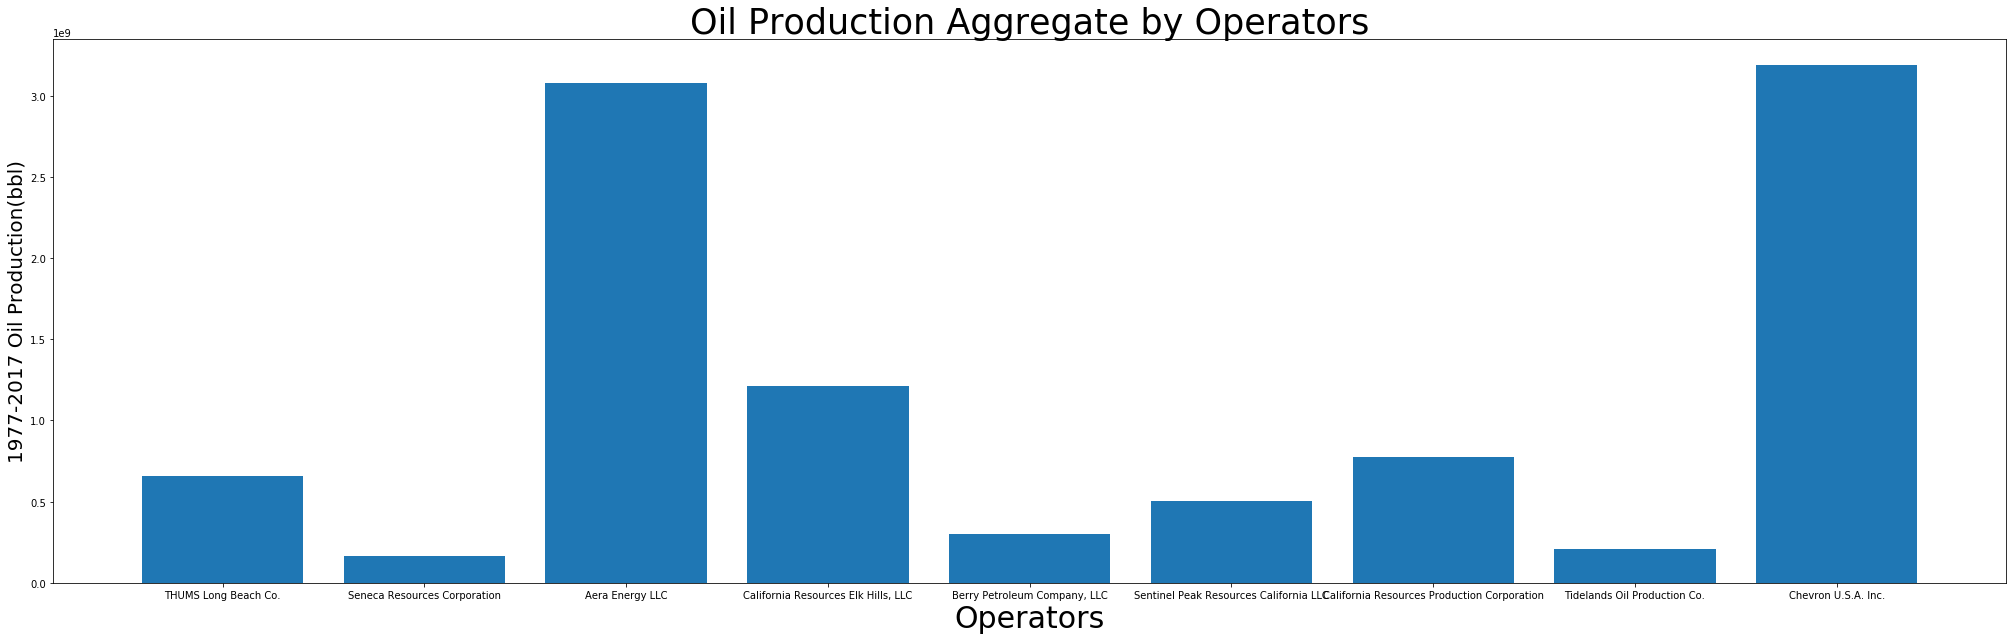

In [8]:
plt.figure(figsize=(35,10))
plt.title('Oil Production Aggregate by Operators', fontsize=35)
plt.ylabel("1977-2017 Oil Production(bbl)",fontsize=20)
plt.bar(range(len(oil_dict)), list(oil_dict.values()), align='center')
plt.xlabel("Operators",fontsize=30)
plt.xticks(range(len(oil_dict)), list(oil_dict.keys()))
plt.savefig('Oil_Production.png')
plt.show()
